# Microstructure simulation chain

Understanding the link between microstructure and material properties is a central challenge in materials science which increasingly relies on high-resolution 3D imaging, large-scale simulations, and data-driven optimization. Let's work through a little example...

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import evoxels as evo
import numpy as np

## Loading data

First, we open a microstructure image (``microstructure.jpg`` in the docs folder) using the pillow package and convert it to a grayscale image (``.convert("L")``). We then re-scale all values to the interval $\psi\in[0,1]$ to further work with our simulations.

Further examples can be found on [microlib.io](https://microlib.io/) or in this [micrograph library](https://www.doitpoms.ac.uk/miclib/index.php).

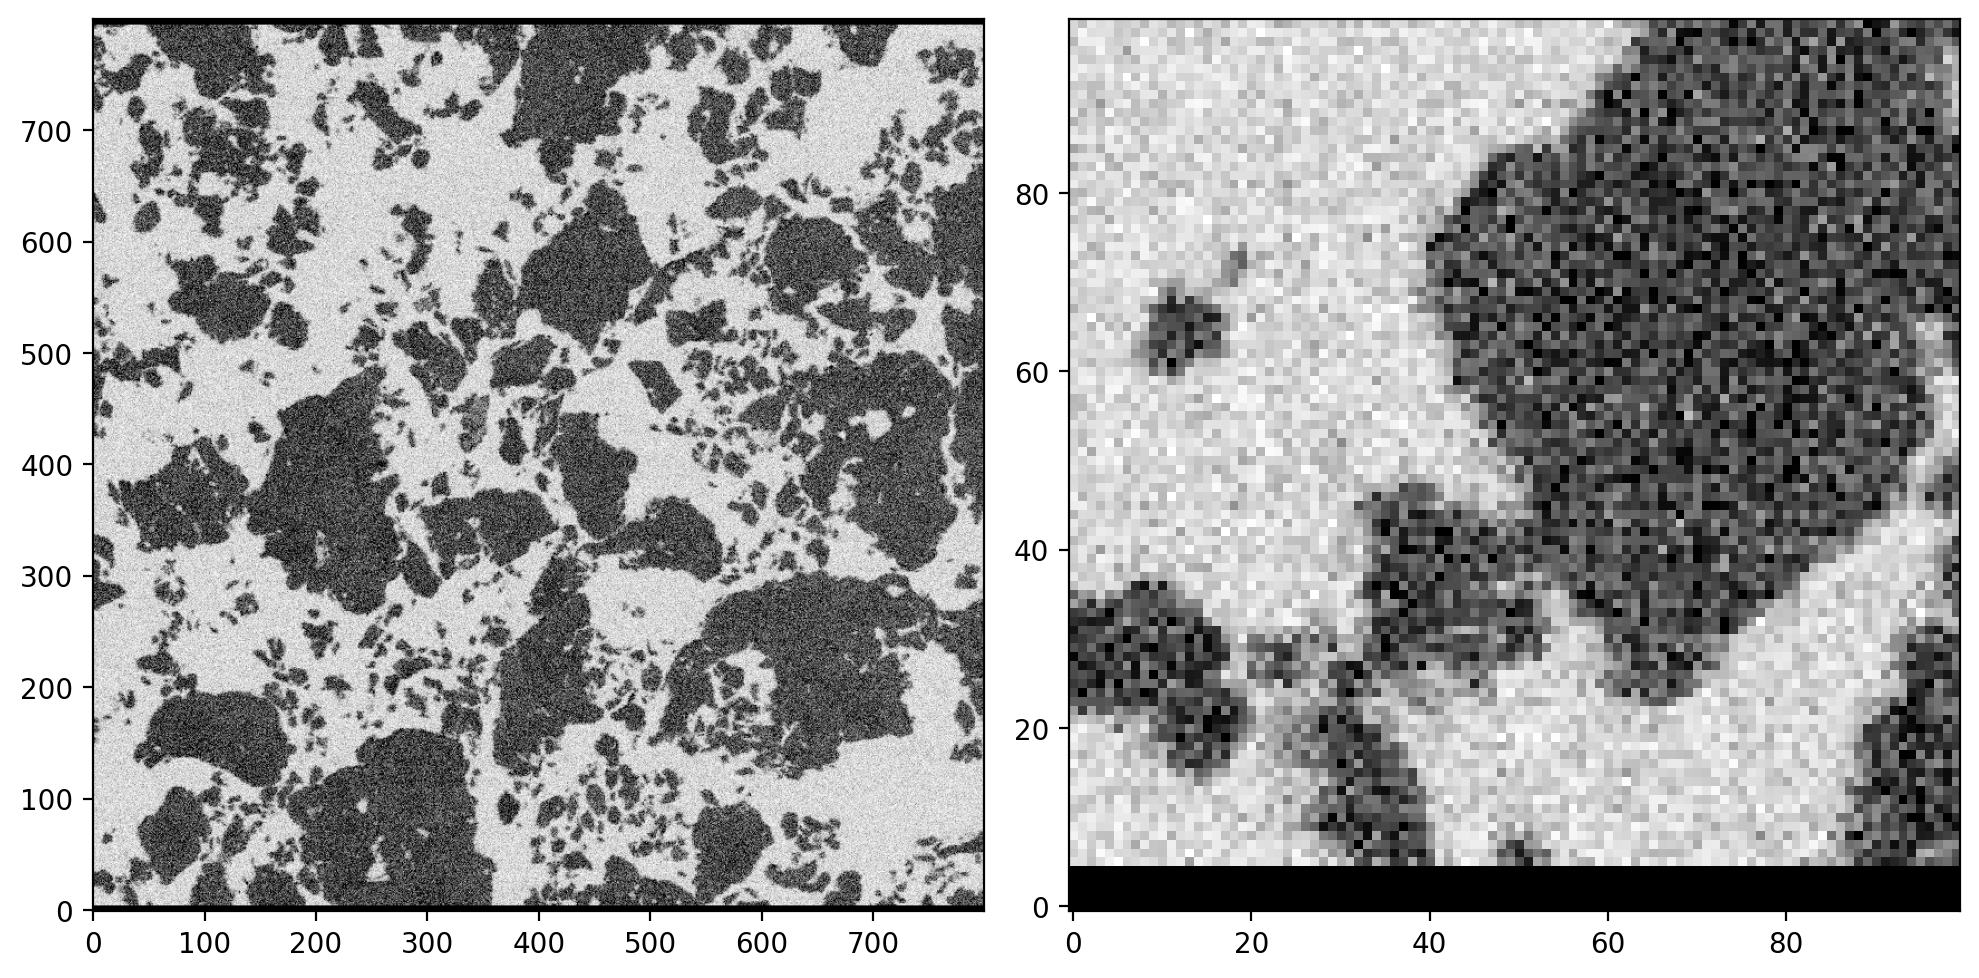

In [2]:
path_to_img = "../microstructure.jpg"
img = Image.open(path_to_img).convert("L")
structure = np.array(img)

psi = (structure-np.min(structure)) / (np.max(structure)-np.min(structure))
psi = 1 - psi
psi[:,:5] = 0
psi[:,-5:] = 0

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8), dpi=200)
axes[0].imshow(psi.T, cmap='gray', origin="lower")
axes[1].imshow(psi[:100,:100].T, cmap='gray', origin="lower")
plt.tight_layout()
plt.show()

We are interested in the connectivity and transport properties of the white phase. The raw image contains a lot of noise which becomes even more obvious when plotting a binary mask where all values below the threshold of $\psi\leq 0.5$ have been set to $0$ and $\psi> 0.5$ to $1$.

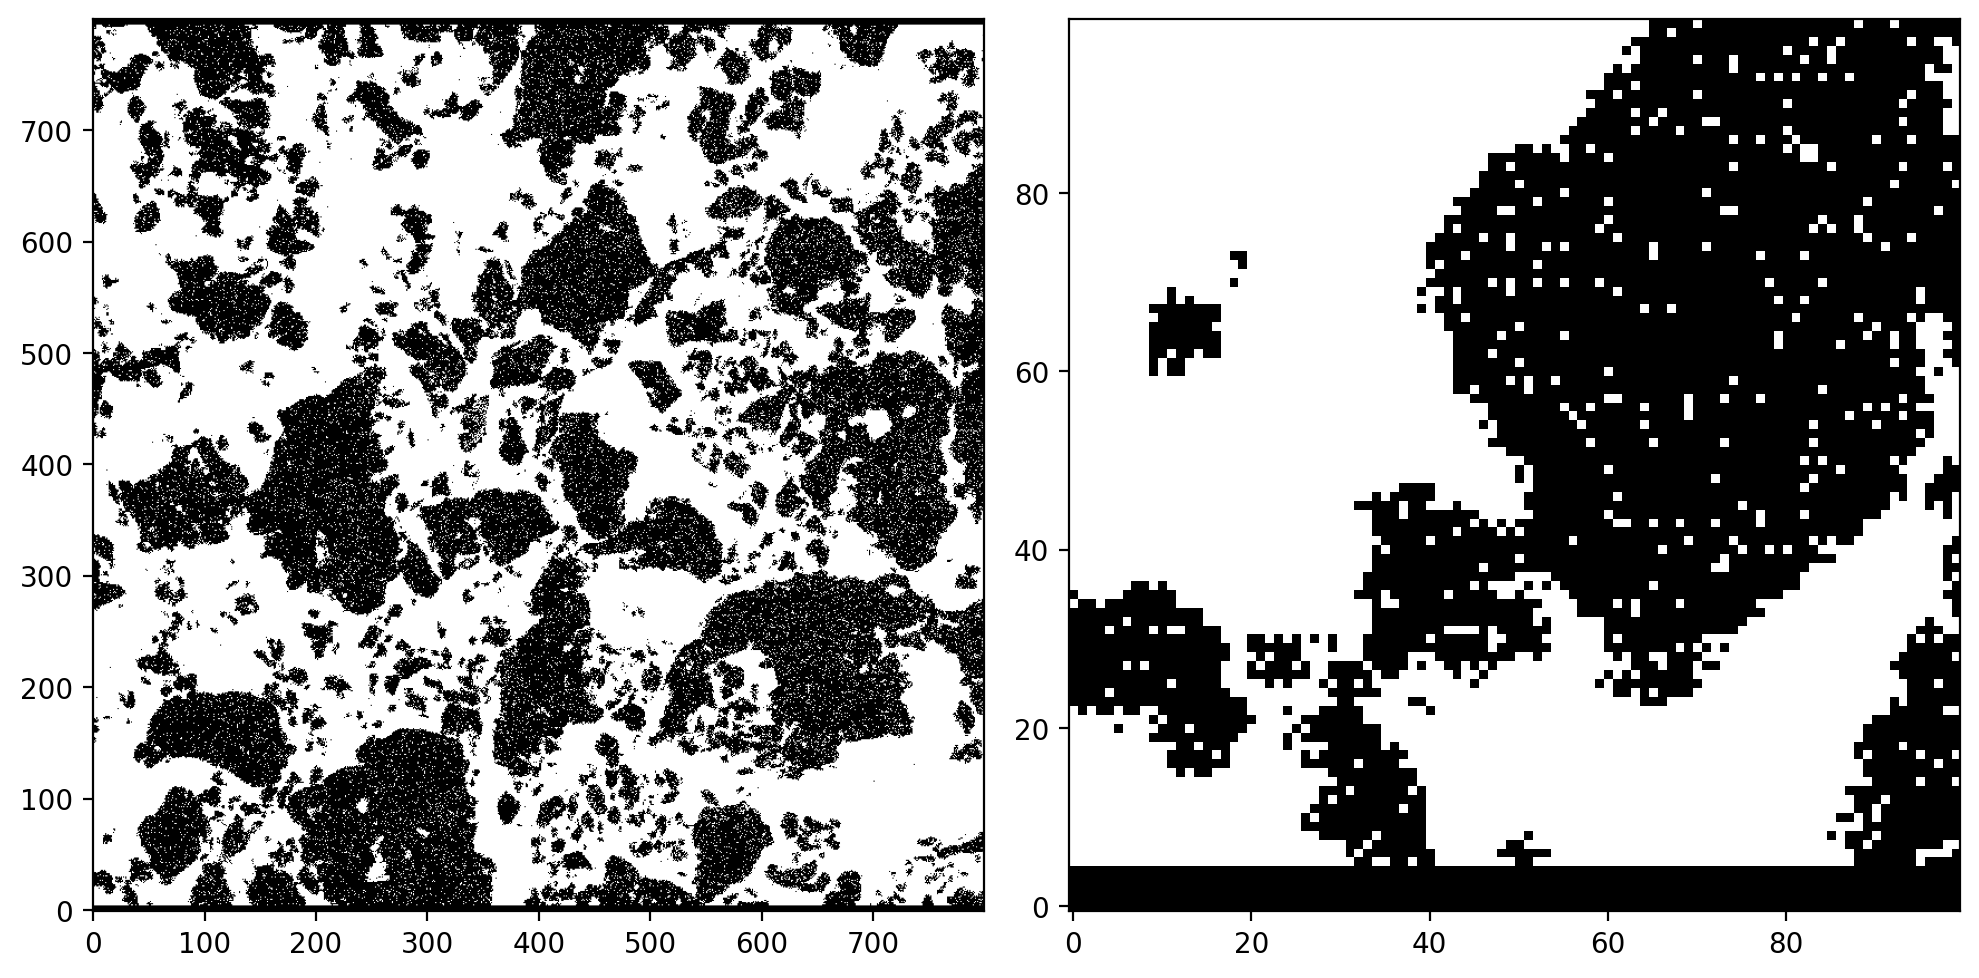

In [3]:
binary = psi.copy()
binary[binary <= 0.5] = 0.0 
binary[binary > 0.5] = 1.0

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8), dpi=200)
axes[0].imshow(binary.T, cmap='gray', origin="lower")
axes[1].imshow(binary[:100,:100].T, cmap='gray', origin="lower")
plt.tight_layout()
plt.show()

## Allen-Cahn equation for phase evolution

We can use the *Allen-Cahn* equation to remove pixel artefacts and to create a smooth transition between the two phases which will later be used in combination with the smoothed boundary method for simulating transport.
Simlarly to the Cahn-Hilliard equation in the previous notebook, the Allen-Cahn equation can be derived from the free energy functional but instead of enforcing mass conservation the first -order phase transformation is derived from the linear relaxation of the system free energy towards its minimum

$$
\frac{\partial\psi}{\partial t}=-L\frac{\delta f}{\delta\psi} = M\left(2\gamma_0\nabla^2\psi - \frac{\gamma_0}{\epsilon} g(\psi) + |\nabla\psi| f \right)
$$

where $M$ [$\text{m}^4$/(Js)] denotes the mobility of the phase boundary, $\gamma_0$ [J/$\text{m}^2$] denotes the interfacial energy and $\epsilon$ [m] scales the width of the diffuse interface. $f$ is a constant driving force acting on the interface to grow or shrink the phase $\psi$. The default implementation in **evoxels** is based on a double well potential $g(\phi)=\frac{18}{\epsilon}\phi(1-\phi)(1-2\phi)$ and, consequently, the gradient norm can be expressed as $|\nabla\psi|\approx \frac{3}{\epsilon} \psi(1-\psi)$. This equation leads to the formation of a diffuse interface and an evolution of the microstructure driven by curvature minimization. More information can be found in the phase-field literature ([Steinbach 2009](https://iopscience.iop.org/article/10.1088/0965-0393/17/7/073001), [Daubner et. al. 2023](https://doi.org/10.1016/j.commatsci.2022.111995), [Hoffrogge et. al. 2025](https://iopscience.iop.org/article/10.1088/1361-651X/ad8d6f)).

An interesting variation is obtained by subtracting the curvature-driven forces from the laplacian of $\psi$ ([Sun and Beckermann 2007](https://doi.org/10.1016/j.jcp.2006.05.025), [Takaki and Kato 2017](https://www.jstage.jst.go.jp/article/mej/4/2/4_16-00462/_article)) such that

$$
\frac{\partial\psi}{\partial t}=M\left(2\gamma_0\left(\nabla^2\psi-|\nabla\psi|\nabla\cdot\frac{\nabla\psi}{|\nabla\psi|}\right) - \frac{\gamma_0}{\epsilon}g(\phi) + |\nabla\psi| f \right).
$$

This will create a smooth transition in the direction of the surface normal, while the shape is not altered by curvature minimization. Instead of subtracting the curvature, the normal part of the laplacian can be computed directly ([Schoof 2020](https://library.oapen.org/handle/20.500.12657/50170))

$$
\nabla^2\psi-|\nabla\psi|\nabla\cdot\frac{\nabla\psi}{|\nabla\psi|}= \nabla(\nabla\psi\cdot\bm{n})\cdot\bm{n}=\nabla|\nabla\psi|\cdot\frac{\nabla\psi}{|\nabla\psi|}.
$$

So let's give this a try...

The above described model comes as a predefined solver which can be called using ``run_allen_cahn_solver``. The ``curvature`` parameter defines the amount of curvature subtraction i.e. ``curvature=0`` means no curvature while for ``curvature=1`` the model reduces to the standard expression with the laplacian.

Wall time: 0.5106 s after 20 iterations (0.0255 s/iter)
GPU-RAM (nvidia-smi)  current: 287 MB (287.0 MB max)
GPU-RAM (torch)       current: 7.33 MB (34.69 MB max, 42.00 MB reserved)


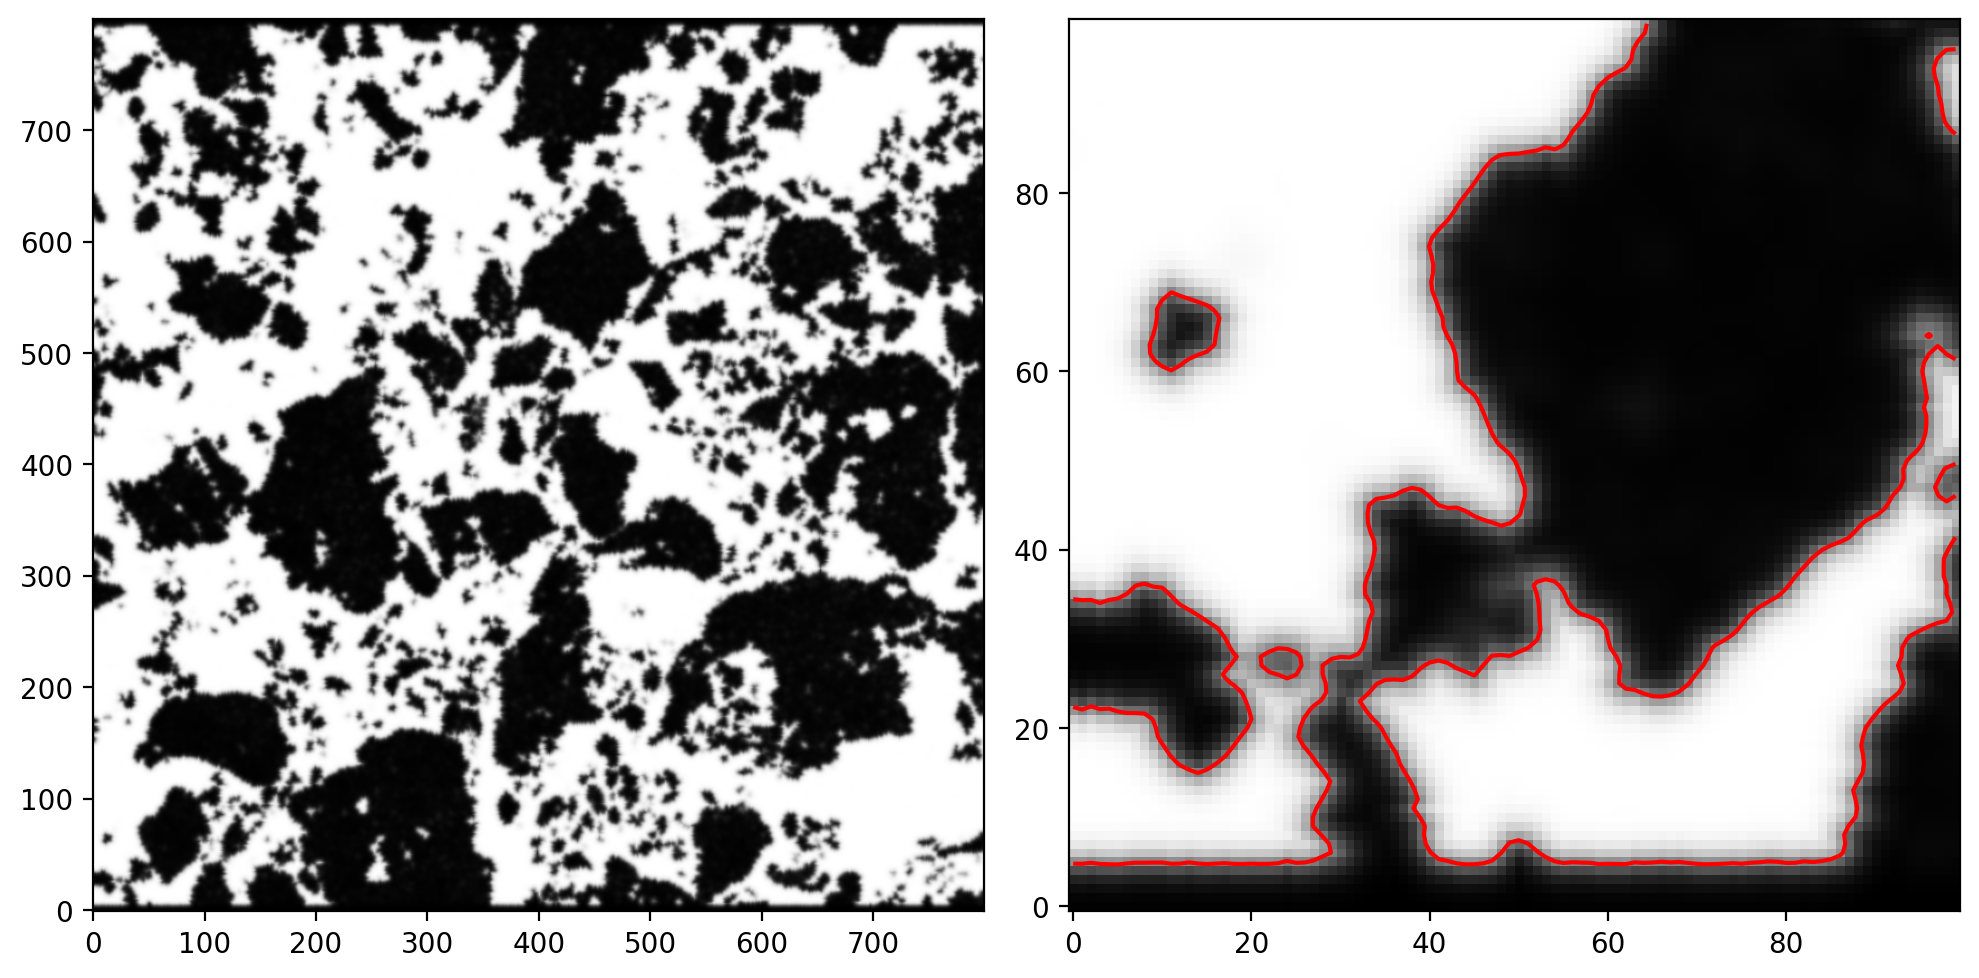

In [4]:
psi = np.expand_dims(psi, -1)
vf = evo.VoxelFields(psi.shape, psi.shape)
vf.add_field('psi', psi)

evo.run_allen_cahn_solver(
    vf, 'psi', 'torch', jit=False, frames=10, max_iters=20,
    eps=3.0, curvature=0.05, verbose=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8), dpi=200)
axes[0].imshow(vf.fields['psi'][:,:,0].T, cmap='gray', origin="lower")
axes[1].imshow(vf.fields['psi'][:100,:100,0].T, cmap='gray', origin="lower")
axes[1].contour(vf.fields['psi'][:100,:100,0].T, levels=[0.5], colors=['red'])
plt.tight_layout()
plt.show()

As discussed by [Daubner and Nestler 2024](https://iopscience.iop.org/article/10.1149/1945-7111/ad9a07), the smooth representation of a voxel-based microstructure with a phase-field variable $\psi$ is actually beneficial in terms of computing the surface area. As shown by the red isoline $\psi=0.5$, the smooth field is a better approximation of the microstructure than a zig-zagging binary mask. Additionally, all the noise has been removed by solving the phase-field equation.

## Smoothed boundary method

To solve the heat/diffusion equation confined to the white part of our microstructure we re-write the diffusion equation with the indicator function $\psi$ as as mask following the procedure described in [Li et.al. 2009](https://doi.org/10.4310/CMS.2009.v7.n1.a4) and [Yu et. al. 2012](https://doi.org/10.1016/j.electacta.2020.136534)

$$
\psi\frac{\partial c}{\partial t}=\nabla\cdot\left(\psi D \nabla c \right) + |\nabla\psi| j_N + \psi f(c,t)
$$

where $j_N$ is the normal boundary flux. The flux $j_N$ can vary spatially and/or temporally and for a closed system $j_N=0$ holds.
If the microstructure does not evolve over time ($\partial\psi/\partial t=0$) the equality $\psi\partial c/\partial t=\partial \psi c/\partial t$ holds. Therefore, we can re-formulate the PDE using $\psi c=z$
$$
\frac{\partial z}{\partial t}=\nabla\cdot\left(D \nabla z - D \frac{z}{\psi}\nabla \psi\right) + |\nabla\psi| j_N +\psi f(c,t)
$$

This formulation is beneficial in terms of generality and the use of FFT based semi-implicit timestepping as discussed in the appendix.

**Note:** in the following solver we combine the smooth boundary method with a ``PseudoSpectralIMEX`` timestepping scheme. The current implementation assumes periodic boundaries in y and z direction for efficiency of the FFT transformation while the boundary conditions in the x direction can be chosen freely (`periodic`, `neumann`, ``dirichlet``). The microstructure can either be made periodic by using generative AI for images such as stable diffusion inpainting or we can set the y- and z-boundary values of the mask to the non-conducting phase to mimic a closed (zero-flux) system.

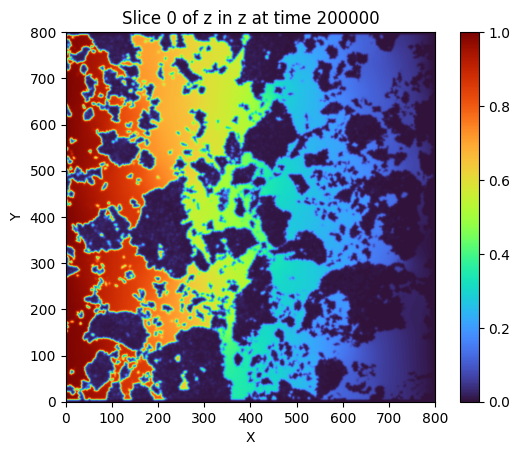

Wall time: 28.1919 s after 4000 iterations (0.007 s/iter)
GPU-RAM (nvidia-smi)  current: 355 MB (355.0 MB max)
GPU-RAM (torch)       current: 24.43 MB (68.44 MB max, 102.00 MB reserved)


In [5]:
from evoxels.solvers import TimeDependentSolver
from evoxels.timesteppers import PseudoSpectralIMEX
from evoxels.problem_definition import ReactionDiffusionSBM

vf.convention='staggered_x'
init = np.expand_dims(np.tile(np.linspace(0.1, 0.0, vf.Nx), (vf.Ny,1)).T, 2)
vf.add_field('z', init * vf.fields['psi'])

problem_kwargs = {\
    "D": 1.0,
    "A": 20,
    "BC_type": 'dirichlet',
    "bcs": (1,0),
    "bc_flux": 0.0,
    "mask": vf.fields['psi']
}
solver = TimeDependentSolver(
        vf, 'z', 'torch', device='cuda',
        problem_cls = ReactionDiffusionSBM,
        timestepper_cls = PseudoSpectralIMEX,
    )
solver.solve(50, 20, 4000, problem_kwargs,
             jit=False, verbose='plot', colormap='turbo', plot_bounds=(0,1))

## Further investigations

We can also combine these tools with other existing libraries such as [taufactor](https://taufactor.readthedocs.io/en/latest/) to further analyse voxel-based image data. Assuming that taufactor has been installed into the same environment via ``pip install taufactor``, we can extract a binary mask from our previous $\psi$ field and start analysing...

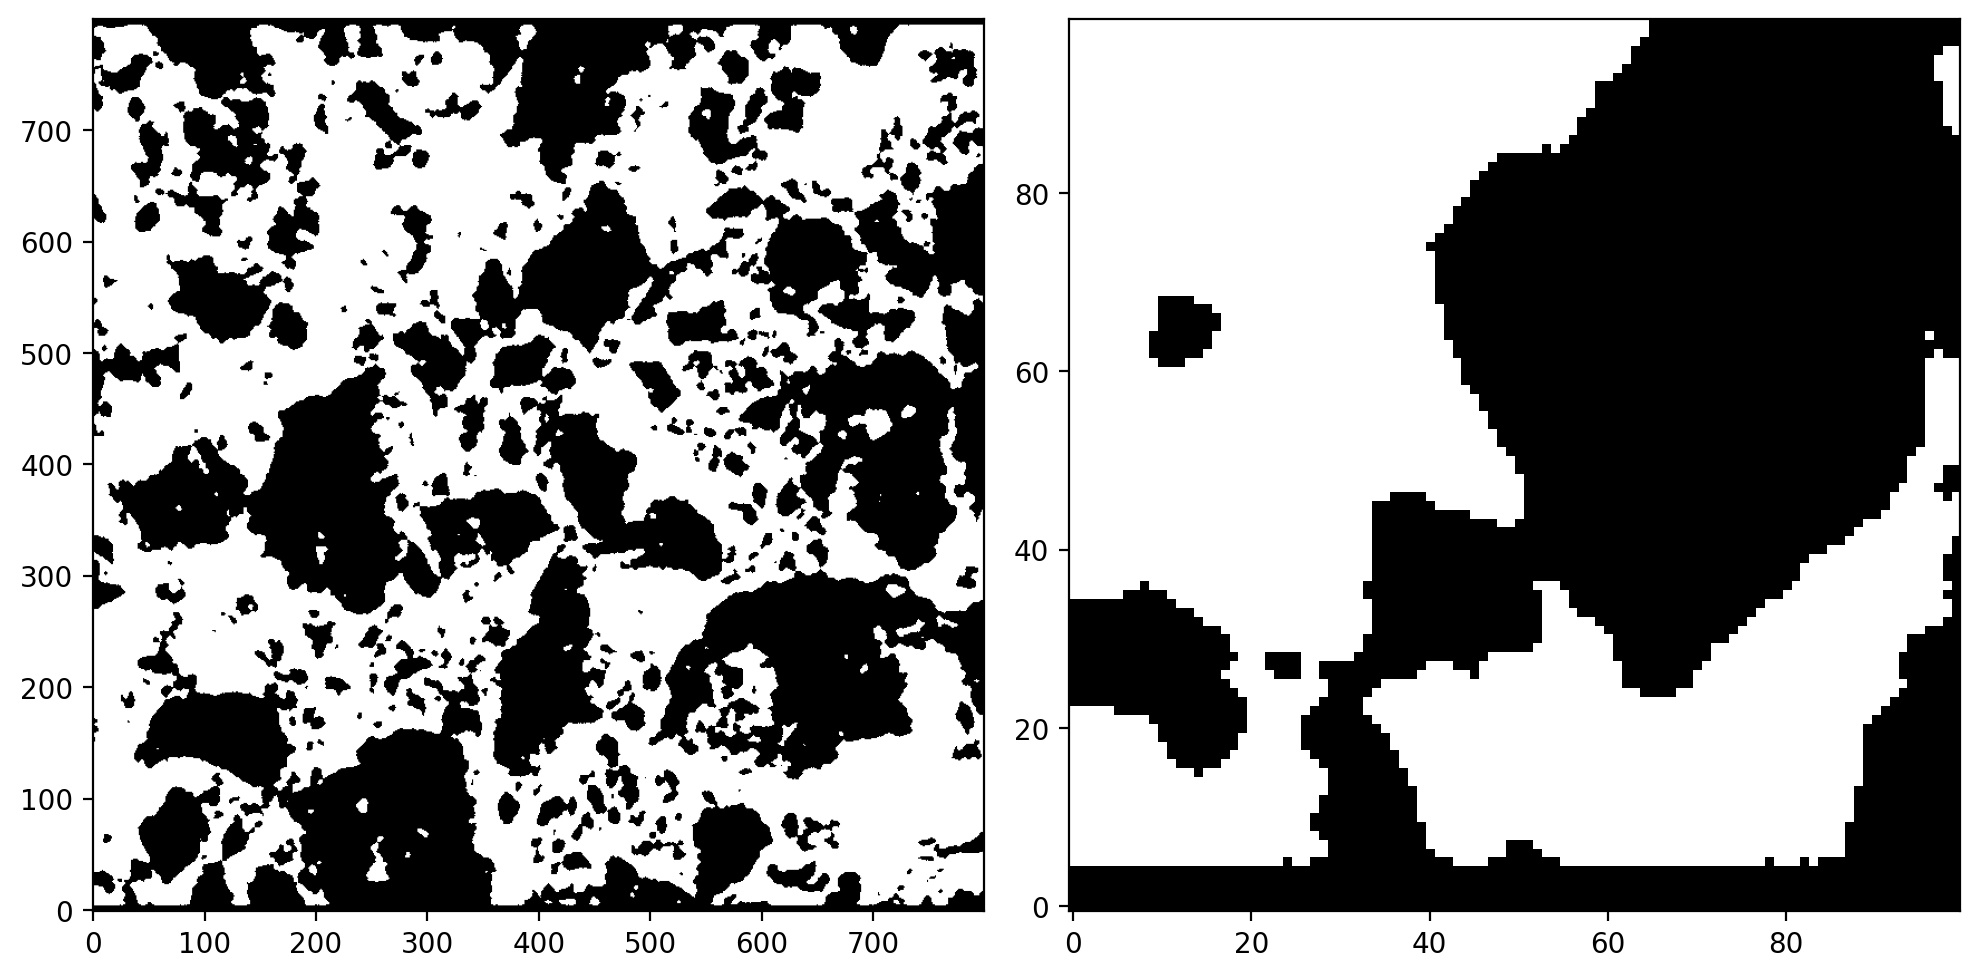

In [6]:
mask = np.where(vf.fields['psi']>0.5)
vf.add_field('binary')
vf.fields['binary'][mask] = 1

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8), dpi=200)
axes[0].imshow(vf.fields['binary'][:,:,0].T, cmap='gray', origin="lower")
axes[1].imshow(vf.fields['binary'][:100,:100,0].T, cmap='gray', origin="lower")
plt.tight_layout()
plt.show()

In [7]:
import taufactor as tau

labels = {'white': 1}
volume = tau.metrics.volume_fraction(vf.fields['binary'], phases=labels)
for key, value in labels.items():
    print(f"Volume fraction of {key} phase: {volume[key]:.4f}")

Volume fraction of white phase: 0.5408


To compute the surface area, we need to stack the image to artificilly create 3D data (otherwise the internal padding, smoothing and gradient computation won't work). As this is a binary microstructure, both white and black will have the same surface area.

In [8]:
stack = np.concatenate((vf.fields['binary'],
                        vf.fields['binary']), 2)

surface = tau.metrics.specific_surface_area(stack, method='gradient', smoothing=True, phases=labels)
for key, value in labels.items():
    print(f"Specific surface area of {key} phase: {surface[key]:.4f}")

Specific surface area of white phase: 0.0482


In [9]:
for key, value in labels.items():
    _, fraction = tau.metrics.extract_through_feature(vf.fields['binary'], value, 'x')
    print(f"Connectivity of {key} phase: {fraction[0]*100:.2f}%")

Connectivity of white phase: 98.68%


Last but not least, we can determine the tortuosity factor $\tau$ of the white phase. $\tau$ describes by which factor the transport becomes slower due to tortuous pathways within the microstructure. It is extracted by solving the steady state of the heat equation with given Dirichlet boundary conditions. 

Iter: 6000, conv error: 6.712E-03, tau: 3.16181 (batch element 0)


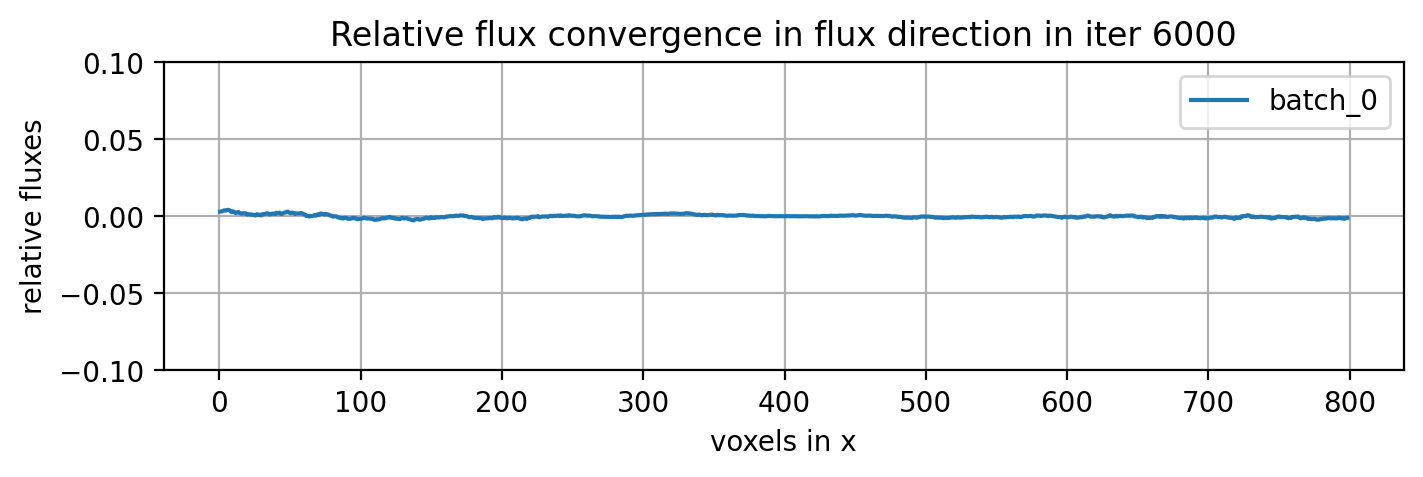

converged to: [3.1623442] after: 6900 iterations in: 4.8013s (0.0007 s/iter)
GPU-RAM currently 38.94 MB (max allocated 44.06 MB; 106.95 MB reserved)


In [10]:
s = tau.Solver(vf.fields['binary'], device='cuda')
tau = s.solve(iter_limit=20000, conv_crit=5e-3, verbose='plot', plot_interval=10)